In [1]:
import os
import torch
import random
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.parallel
from logging import critical

import torch.optim as optim

random.seed(19)
torch.manual_seed(19)
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [ ]:
!wget https://github.com/punsiwoot/my_first_anime_generator/raw/main/data.zip
!unzip '/content/data.zip'

In [ ]:
#precessing

image_size = 256
batch_size = 32
dataset = dset.ImageFolder(root="/content/data",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

torch.Size([32, 3, 256, 256])

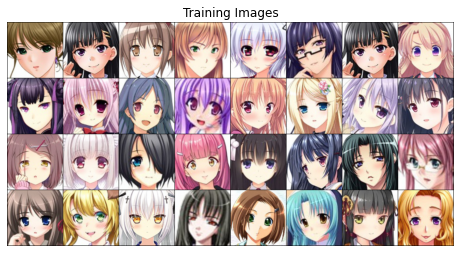

In [ ]:
import torchvision.utils as vutils
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True),(1,2,0)))
real_batch[0].shape

In [ ]:
# custom weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# see number of parameter
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
class gen(nn.Module):
  def __init__(self,ngpu):
    super().__init__()
    self.ngpu = ngpu
    self.model =  nn.Sequential(
        # nn.ConvTranspose2d(100, 512, 4, 2, 1, bias=False),
        # nn.BatchNorm2d(512),
        # nn.ReLU(True),
        # nn.ConvTranspose2d( 512, 256 , 4, 2, 1, bias=False),
        # nn.BatchNorm2d(256),
        # nn.ReLU(True),
        # nn.ConvTranspose2d( 256, 128, 6, 4, 1, bias=False),
        # nn.BatchNorm2d(128),
        # nn.ReLU(True),
        # nn.ConvTranspose2d( 128, 64, 6, 4, 1, bias=False),
        # nn.BatchNorm2d(64),
        # nn.ReLU(True),
        # nn.ConvTranspose2d( 64, 3, 6, 4, 1, bias=False),
        # nn.Tanh()
        nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False),
        nn.BatchNorm2d(1024),
        nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d( 512, 256 , 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d( 64, 3, 6, 4, 1, bias=False),
        nn.Tanh()
    )
  def forward(self,x):
        # print("---------------------------------------------")
        # print(f"print input shape of generator {x.shape}")
        x = self.model(x)
        # print(f"print output shape of generator {x.shape}")
        # print("---------------------------------------------")
        return x

class dis(nn.Module):
    def __init__(self,ngpu):
      super().__init__()
      self.ngpu = ngpu
      self.model = nn.Sequential(
            nn.Conv2d(3,64,6,4,1,bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 5, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128 , 256, 5, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 6, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 6 ,1, 0, bias=False),
            nn.Sigmoid()
      )
    def forward(self, x):
        # print("---------------------------------------------")
        # print(f'print input of disriminator {x.shape}')
        x = self.model(x)
        # print(f'print output of disriminator {x.shape}')
        # print("---------------------------------------------")
        return x

generator = gen(ngpu).to(device)
discriminator = dis(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))


discriminator.apply(weights_init)
generator.apply(weights_init)
lr = 0.0001
epochs = 32
criterion = nn.BCELoss()

true_labels = torch.ones((batch_size, 1))
false_labels = torch.zeros((batch_size, 1))


optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

print(discriminator)
print(generator)

# print(discriminator)
# print(generator)
laa = torch.randn(1,100,1,1,device=device)
# print(f" this is test 1 latent : {laa}")
test = generator(laa)
# test2 = discriminator(test)

dis(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
gen(
  (model): Sequential(
    (0): Co

In [ ]:

print(count_parameters(generator))
print(count_parameters(discriminator))

12790400
5769728


In [ ]:
#main repeat 5 time
loss_dis_array = []
loss_gen_array = []
keep_gen_evolution = []
latent_test = torch.randn(batch_size,100,1,1, device=device)

for epoch in range(epochs) :
  for n,(set_image,_) in enumerate(dataloader):
    #train discriminator
    discriminator.zero_grad()
    discriminator_train_real = discriminator(set_image.to(device))
    loss_dis_real = criterion(discriminator_train_real.view(discriminator_train_real.shape[0],1),torch.ones((discriminator_train_real.shape[0], 1,),device=device))
    loss_dis_real.backward()

    #train generator for discriminator
    train_latent_space = torch.randn(batch_size,100,1,1,device=device)    ####if use rand it will boommmmmmmmm
    generator_train_latent = generator(train_latent_space)
    discriminator_train_latent = discriminator(generator_train_latent.detach())
    loss_dis_from_gen = criterion(discriminator_train_latent.view(discriminator_train_latent.shape[0],1),torch.zeros((discriminator_train_latent.shape[0], 1),device=device))
    loss_dis_from_gen.backward()

    all_loss_dis = loss_dis_real.item()+loss_dis_from_gen.item()  #for visualize  array
    optimizerD.step()

    #train gen
    generator.zero_grad()
    discriminator_train_latent = discriminator(generator_train_latent)
    loss_gen_latent = criterion(discriminator_train_latent.view(32,1),torch.ones((discriminator_train_latent.shape[0], 1),device=device))
    loss_gen_latent.backward()
    optimizerG.step()
    
  print(f" epoch : {epoch},  loss_gen : {loss_gen_latent.item()}, loss_dis : {all_loss_dis} ")
  loss_dis_array.append(all_loss_dis)
  loss_gen_array.append(loss_gen_latent.item())
  keep_gen_evolution.append(generator(latent_test))

 epoch : 0,  loss_gen : 4.893280506134033, loss_dis : 0.04271538369357586 
 epoch : 1,  loss_gen : 5.008141040802002, loss_dis : 0.037907871417701244 
 epoch : 2,  loss_gen : 5.912230014801025, loss_dis : 0.010412650648504496 
 epoch : 3,  loss_gen : 3.484117269515991, loss_dis : 0.0753257586620748 
 epoch : 4,  loss_gen : 5.187205791473389, loss_dis : 0.029715838842093945 
 epoch : 5,  loss_gen : 6.441559791564941, loss_dis : 0.008432719972915947 
 epoch : 6,  loss_gen : 4.626969337463379, loss_dis : 0.03551967395469546 
 epoch : 7,  loss_gen : 5.6897993087768555, loss_dis : 0.02802653657272458 
 epoch : 8,  loss_gen : 5.190301418304443, loss_dis : 0.01954913605004549 
 epoch : 9,  loss_gen : 4.905706405639648, loss_dis : 0.029123949818313122 
 epoch : 10,  loss_gen : 5.625265121459961, loss_dis : 0.012536314548924565 
 epoch : 11,  loss_gen : 5.848231315612793, loss_dis : 0.017705236561596394 
 epoch : 12,  loss_gen : 6.154300689697266, loss_dis : 0.011280397418886423 
 epoch : 13,  

In [ ]:
latent_space_test = torch.randn(1,100,1,1,device=device)
result = generator(latent_space_test).cpu().detach().numpy()
print(result.shape)
# plt.imshow(np.transpose(result[-1],(1,2,0)))
plt.show()

(1, 3, 256, 256)


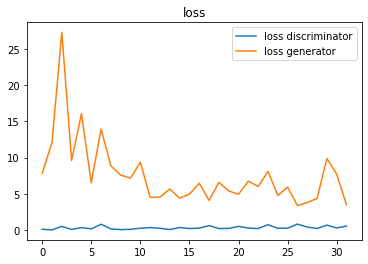

In [ ]:
plt.title('loss')
plt.plot(loss_dis_array,label='loss discriminator')
plt.plot(loss_gen_array, label='loss generator')
plt.legend()
plt.show()

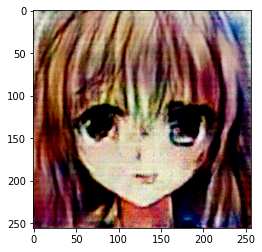

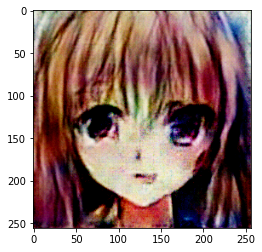

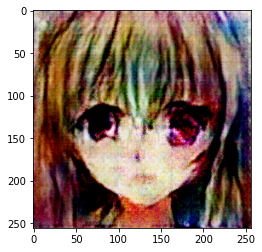

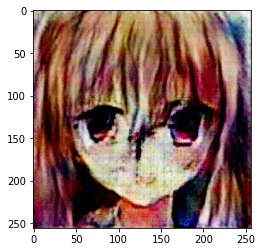

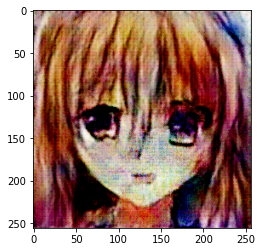

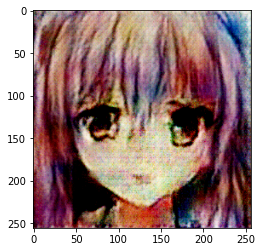

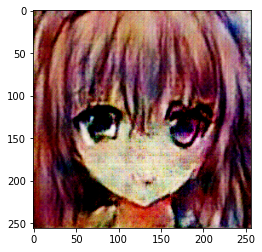

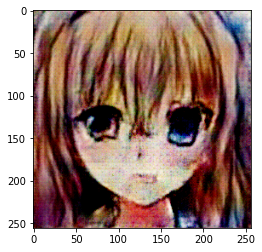

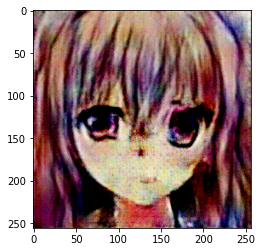

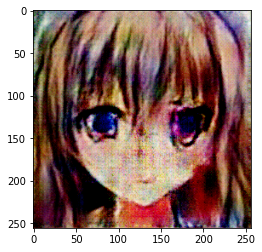

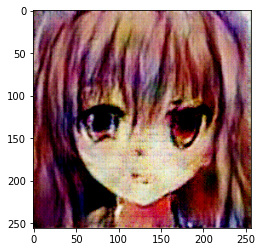

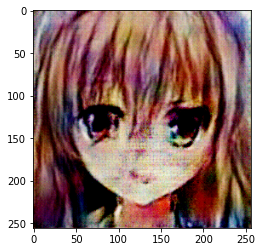

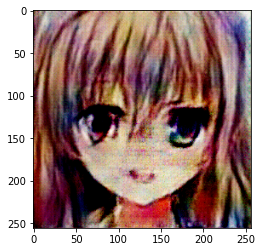

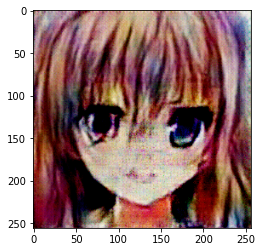

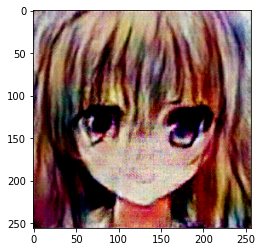

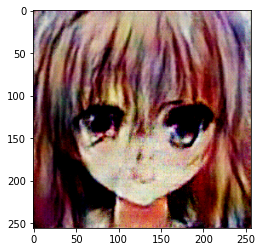

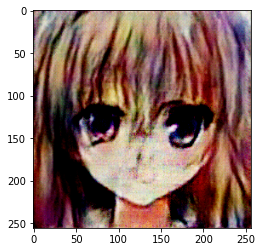

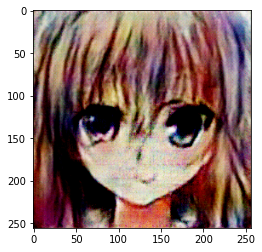

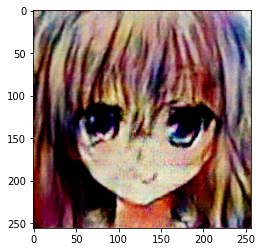

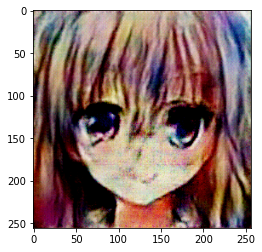

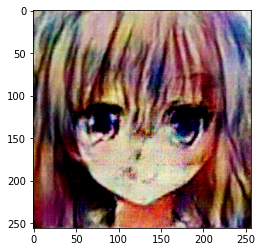

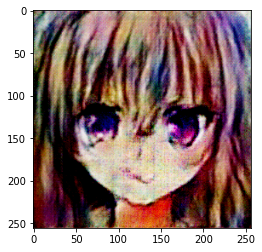

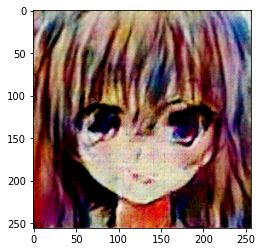

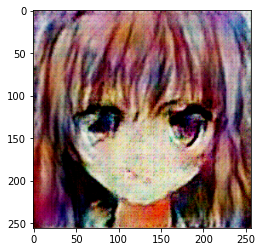

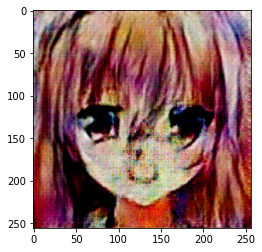

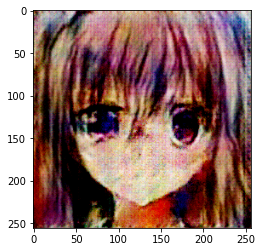

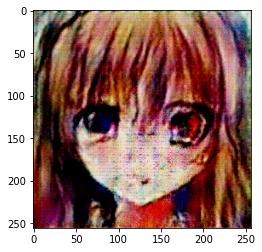

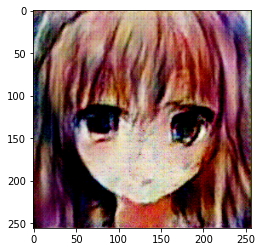

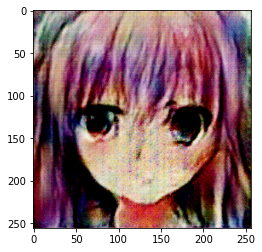

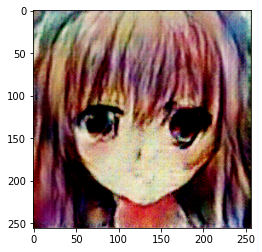

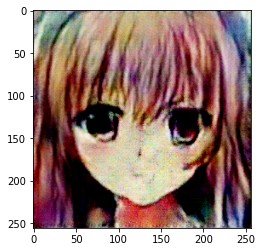

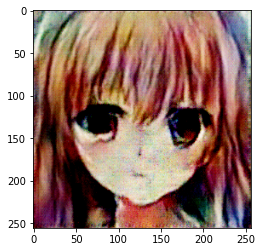

In [ ]:
for i in keep_gen_evolution :
  plt.imshow(np.transpose(i.cpu().detach().numpy()[-1],(1,2,0)))
  plt.show()


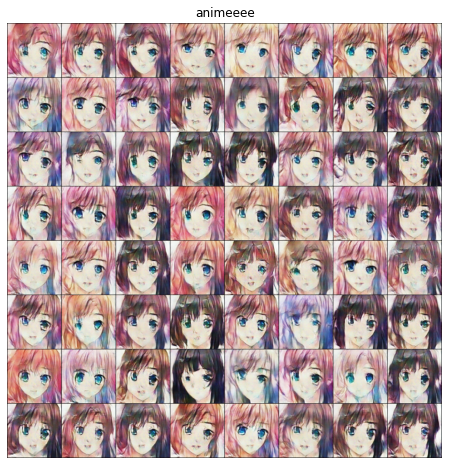

In [ ]:
test_latent_space = torch.rand(64,100,1,1,device=device)
test = generator(test_latent_space)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("animeeee")
plt.imshow(np.transpose(vutils.make_grid(test[:64].cpu(), padding=2, normalize=True),(1,2,0)))

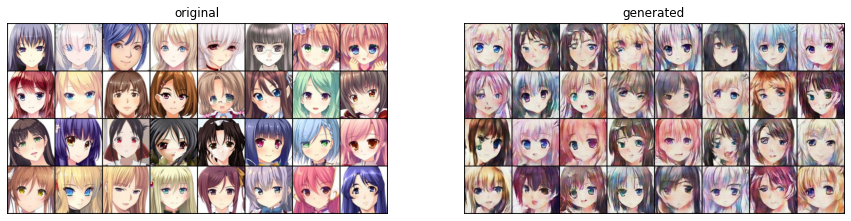

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("original")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("generated")
plt.imshow(np.transpose(vutils.make_grid(keep_gen_evolution[-1][:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
PATH = '/content/save_model_checkpoint_5.pt'
torch.save(generator.state_dict(), PATH)